In [145]:
# Importing the neccessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, RocCurveDisplay, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import label_binarize, LabelBinarizer
import pickle

## Reading the data

In [2]:
df = pd.read_csv("processed_data.csv")
df.head()

,type,breed,color,sex,size,intake_type,intake_subtype,intake_condition,intake_jurisdiction,intake_total,age,intake_date,days_in_shelter,has_name,outcome_type
0,1,650,293,3,5,6,3,3,11,1,2,1688515200,34,1,ADOPTION
1,0,409,218,3,0,6,20,3,9,1,0,1685404800,70,1,ADOPTION
2,0,409,94,0,4,6,20,3,11,1,3,1689379200,24,1,TRANSFER
3,1,805,293,2,4,6,3,3,11,1,4,1682380800,85,1,ADOPTION
4,1,829,153,1,4,6,20,0,9,1,0,1691452800,0,1,RETURN TO OWNER


In [3]:
df['outcome_type'].value_counts()

RETURN TO OWNER    8606
ADOPTION           7533
TRANSFER           5439
EUTHANIZE          3552
DISPOSAL            235
DIED                171
RTOS                 49
ESCAPED/STOLEN       17
Name: outcome_type, dtype: int64

## Splitting the data by the predictor variables and the target variable

In [4]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

## Splitting the data into train and test sets

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [146]:
# Label encode the target variable y_train
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Modelling

In [6]:
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(zip(np.unique(y_train), class_weights))

In [154]:
# For getting the best hyperparameters
def hyperparameter_tuning(model, param_dist, n_iter):
    # Create RandomizedSearchCV
    random_search = RandomizedSearchCV(
        model,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring='roc_auc_ovr',  # Using 'roc_auc_ovr' for multiclass AUC
        cv=3,
        n_jobs=-1,
        random_state=42
    )

    # Fit the RandomizedSearchCV
    random_search.fit(X_train, y_train)

    # Get the best parameters
    best_params = random_search.best_params_
    
    return best_params


def xgb_hyperparameter_tuning(model, param_dist, n_iter):
    # Create RandomizedSearchCV
    random_search = RandomizedSearchCV(
        model,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring='roc_auc_ovr',  # Using 'roc_auc_ovr' for multiclass AUC
        cv=3,
        n_jobs=-1,
        random_state=42
    )

    # Fit the RandomizedSearchCV
    random_search.fit(X_train, y_train_encoded)

    # Get the best parameters
    best_params = random_search.best_params_
    
    return best_params


def grid_hyperparameter_tuning(model, param_dist):
    # Create GridSearchCV
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_dist,
        scoring='roc_auc_ovr',  # Using 'roc_auc_ovr' for multiclass AUC
        cv=3,
        n_jobs=-1
    )

    # Fit the RandomizedSearchCV
    grid_search.fit(X_train, y_train)

    # Get the best parameters
    best_params = grid_search.best_params_
    
    return best_params


# For evaluating model's performance
def eval_model(model, y_train, y_test):
    # Make predictions on the train set
    y_pred = model.predict(X_train)
    
    # Calculate training accuracy score
    accuracy = accuracy_score(y_train, y_pred)
    print("Training Accuracy Score:", accuracy)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Calculate test accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    print("Test Accuracy Score:", accuracy)
    
    # Generate classification report
    class_report = classification_report(y_test, y_pred, zero_division=1)
    print("\n\nClassification Report:\n", class_report)
    
    
def roc_auc_score_per_class(model, y_test):
    # Make predictions on the test set
    y_prob = model.predict_proba(X_test)

    # Calculate ROC-AUC score for each class
    roc_auc_per_class = roc_auc_score(y_test, y_prob, average=None, multi_class='ovr')

    # Calculate macro-average ROC-AUC score
    roc_auc_macro = np.mean(roc_auc_per_class)

    # Get the class labels from the trained classifier
    class_labels = model.classes_

    # Print ROC-AUC scores for each class
    for i, roc_auc in enumerate(roc_auc_per_class):
        print(f"Class {class_labels[i]} ROC-AUC: {roc_auc:.2f}")
        
        
def generate_roc_curve(model, y_train, y_test):
    # ROC_AUC Curve 
    label_binarizer = LabelBinarizer().fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)
    y_onehot_test.shape  # (n_samples, n_classes)
    
    # Make predictions on the test set
    y_prob = model.predict_proba(X_test)
    
    # Get the class labels from the trained classifier
    class_labels = model.classes_

    fig, ax = plt.subplots(figsize=(12, 10))
    n_classes = 8
    colors = cycle(["aqua", "darkorange", "cornflowerblue", "red", 'blue', 'green', 'purple', 'pink'])
    for class_id, color in zip(range(n_classes), colors):
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_prob[:, class_id],
            name=f"ROC Curve for {class_labels[class_id]}",
            color=color,
            ax=ax,
            plot_chance_level=(class_id == 2),
        )

    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC - Curve")
    plt.legend()
    plt.show()

## 1) Base Model - RF

In [161]:
best_rf = RandomForestClassifier(random_state=42)
best_rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [162]:
eval_model(best_rf, y_train, y_test)

Training Accuracy Score: 0.9996582198134857
Test Accuracy Score: 0.8510056629564539


Classification Report:
                  precision    recall  f1-score   support

       ADOPTION       0.82      0.94      0.87      1530
           DIED       1.00      0.23      0.37        40
       DISPOSAL       0.64      0.33      0.44        48
 ESCAPED/STOLEN       1.00      0.00      0.00         3
      EUTHANIZE       0.88      0.78      0.83       714
RETURN TO OWNER       0.92      0.94      0.93      1688
           RTOS       1.00      0.07      0.13        14
       TRANSFER       0.77      0.70      0.73      1084

       accuracy                           0.85      5121
      macro avg       0.88      0.50      0.54      5121
   weighted avg       0.85      0.85      0.85      5121



In [163]:
roc_auc_score_per_class(best_rf, y_test)

Class ADOPTION ROC-AUC: 0.97
Class DIED ROC-AUC: 0.85
Class DISPOSAL ROC-AUC: 0.93
Class ESCAPED/STOLEN ROC-AUC: 0.49
Class EUTHANIZE ROC-AUC: 0.97
Class RETURN TO OWNER ROC-AUC: 0.99
Class RTOS ROC-AUC: 0.80
Class TRANSFER ROC-AUC: 0.93


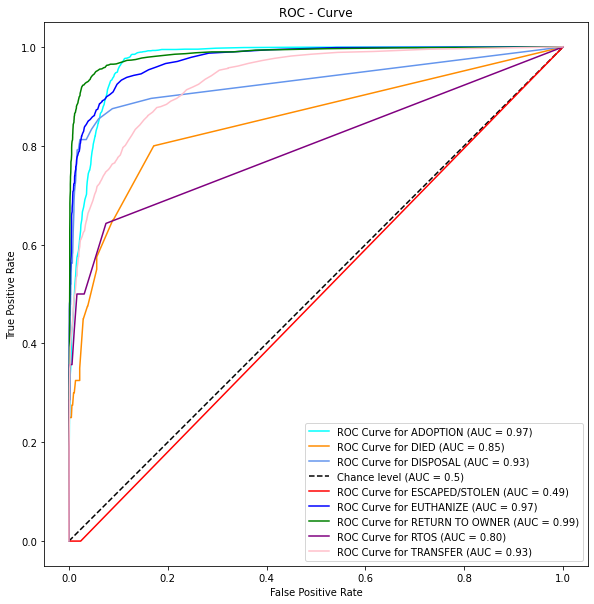

In [164]:
generate_roc_curve(best_rf, y_train, y_test)

## 2) Random Forest Classifier

In [8]:
# Hyperparameter tuning
# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': np.arange(100, 1000, 50),
    'max_depth': [None] + list(np.arange(10, 110, 10)),
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split': np.arange(2, 11),
    'min_samples_leaf': np.arange(1, 11),
    'bootstrap': [True, False]
}

# Create a Random Forest classifier for multi-class
rf = RandomForestClassifier(random_state=42)

# Get the best parameters
best_params = hyperparameter_tuning(model=rf, param_dist=param_dist, n_iter=300)

best_params

D:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
276 fits failed out of a total of 900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda3\lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "D:\Anaconda3\lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "D:\Anaconda3\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate

{'n_estimators': 450,
 'min_samples_split': 9,
 'min_samples_leaf': 5,
 'max_features': 'log2',
 'max_depth': 100,
 'bootstrap': False}

In [9]:
# Train the model with best parameters
best_rf = RandomForestClassifier(random_state=42, **best_params, class_weight=class_weights_dict)
# best_rf = RandomForestClassifier(random_state=42, class_weight=class_weights_dict)
best_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False,
                       class_weight={'ADOPTION': 0.4264742628685657,
                                     'DIED': 19.54293893129771,
                                     'DISPOSAL': 13.690508021390375,
                                     'ESCAPED/STOLEN': 182.86607142857142,
                                     'EUTHANIZE': 0.9020877378435518,
                                     'RETURN TO OWNER': 0.37006721595836944,
                                     'RTOS': 73.14642857142857,
                                     'TRANSFER': 0.5878587830080367},
                       max_depth=100, max_features='log2', min_samples_leaf=5,
                       min_samples_split=9, n_estimators=450, random_state=42)

In [10]:
eval_model(best_rf)

Training Accuracy Score: 0.9314974854743421
Test Accuracy Score: 0.8344073423159539


Classification Report:
                  precision    recall  f1-score   support

       ADOPTION       0.82      0.92      0.87      1530
           DIED       0.31      0.28      0.29        40
       DISPOSAL       0.34      0.69      0.46        48
 ESCAPED/STOLEN       0.00      0.00      1.00         3
      EUTHANIZE       0.87      0.77      0.82       714
RETURN TO OWNER       0.94      0.91      0.92      1688
           RTOS       0.67      0.14      0.24        14
       TRANSFER       0.73      0.68      0.71      1084

       accuracy                           0.83      5121
      macro avg       0.59      0.55      0.66      5121
   weighted avg       0.84      0.83      0.83      5121



In [11]:
roc_auc_score_per_class(best_rf)

Class ADOPTION ROC-AUC: 0.97
Class DIED ROC-AUC: 0.88
Class DISPOSAL ROC-AUC: 0.96
Class ESCAPED/STOLEN ROC-AUC: 0.90
Class EUTHANIZE ROC-AUC: 0.97
Class RETURN TO OWNER ROC-AUC: 0.98
Class RTOS ROC-AUC: 0.96
Class TRANSFER ROC-AUC: 0.93


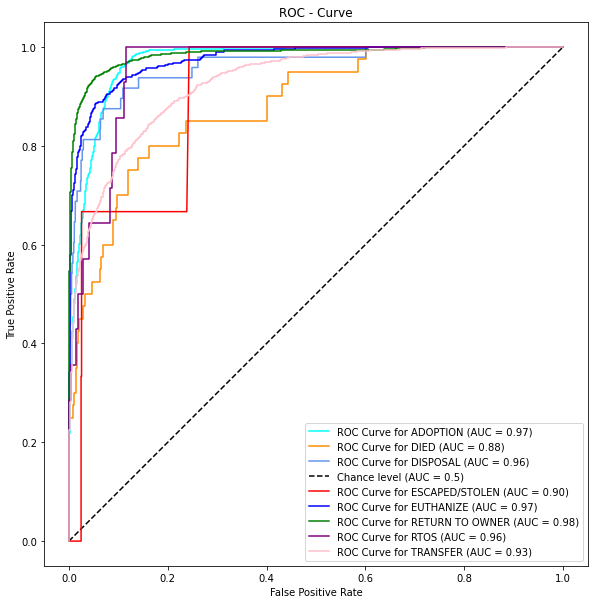

In [12]:
generate_roc_curve(best_rf)

In [13]:
# # Save the model to a file using pickle
# with open('rf_model.pkl', 'wb') as file:
#     pickle.dump(best_rf, file)

## 3) Light GBM

In [106]:
# Hyperparameter tuning
# Define parameter grid for RandomizedSearchCV
param_dist = {
    'boosting_type': ['gbdt', 'dart', 'goss'],
    'num_leaves': np.arange(20, 200),
    'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2],
    'subsample': np.linspace(0.20, 1, num=100),
    'colsample_bytree': [1, 2],
    'max_bin': [32, 64, 128],
    'max_depth': [1, 2],
    'objective': ['multiclass'],
    'num_class': [8]
}

# Create a LightGBM classifier
lgb_classifier = lgb.LGBMClassifier()

# Get the best parameters
best_params = hyperparameter_tuning(model=lgb_classifier, param_dist=param_dist, n_iter=300)

best_params

D:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
420 fits failed out of a total of 900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
420 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 1142, in fit
    super().fit(
  File "D:\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 842, in fit
    self._Booster = train(
  File "D:\Anaconda3\lib\site-packages\lightgbm\engine.py", line 245, in train
    booster = Booster(params=params, train_set=trai

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 192
[LightGBM] [Info] Number of data points in the train set: 20481, number of used features: 14
[LightGBM] [Info] Start training from score -1.227238
[LightGBM] [Info] Start training from score -5.052056
[LightGBM] [Info] Start training from score -4.696144
[LightGBM] [Info] Start training from score -7.288196
[LightGBM] [Info] Start training from score -1.976398
[LightGBM] [Info] Start training from score -1.085371
[LightGBM] [Info] Start training from score -6.371905
[LightGBM] [Info] Start training from score -1.548173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


{'subsample': 0.8383838383838385,
 'objective': 'multiclass',
 'num_leaves': 112,
 'num_class': 8,
 'max_depth': 2,
 'max_bin': 32,
 'learning_rate': 0.1,
 'colsample_bytree': 1,
 'boosting_type': 'gbdt'}

In [119]:
np.linspace(0.20, 1, num=100)

array([0.2       , 0.20808081, 0.21616162, 0.22424242, 0.23232323,
       0.24040404, 0.24848485, 0.25656566, 0.26464646, 0.27272727,
       0.28080808, 0.28888889, 0.2969697 , 0.30505051, 0.31313131,
       0.32121212, 0.32929293, 0.33737374, 0.34545455, 0.35353535,
       0.36161616, 0.36969697, 0.37777778, 0.38585859, 0.39393939,
       0.4020202 , 0.41010101, 0.41818182, 0.42626263, 0.43434343,
       0.44242424, 0.45050505, 0.45858586, 0.46666667, 0.47474747,
       0.48282828, 0.49090909, 0.4989899 , 0.50707071, 0.51515152,
       0.52323232, 0.53131313, 0.53939394, 0.54747475, 0.55555556,
       0.56363636, 0.57171717, 0.57979798, 0.58787879, 0.5959596 ,
       0.6040404 , 0.61212121, 0.62020202, 0.62828283, 0.63636364,
       0.64444444, 0.65252525, 0.66060606, 0.66868687, 0.67676768,
       0.68484848, 0.69292929, 0.7010101 , 0.70909091, 0.71717172,
       0.72525253, 0.73333333, 0.74141414, 0.74949495, 0.75757576,
       0.76565657, 0.77373737, 0.78181818, 0.78989899, 0.79797

In [107]:
# Train the model with best parameters
best_lgbm = lgb.LGBMClassifier(random_state=42, **best_params)
# best_lgbm = LGBMClassifier(random_state=42)
best_lgbm.fit(X_train, y_train)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000702 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 192
[LightGBM] [Info] Number of data points in the train set: 20481, number of used features: 14
[LightGBM] [Info] Start training from score -1.227238
[LightGBM] [Info] Start training from score -5.052056
[LightGBM] [Info] Start training from score -4.696144
[LightGBM] [Info] Start training from score -7.288196
[LightGBM] [Info] Start training from score -1.976398
[LightGBM] [Info] Start training from score -1.085371
[LightGBM] [Info] Start training from score -6.371905
[LightGBM] [Info] Start training from score -1.548173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMClassifier(colsample_bytree=1, max_bin=32, max_depth=2, num_class=8,
               num_leaves=112, objective='multiclass', random_state=42,
               subsample=0.8383838383838385)

In [108]:
eval_model(best_lgbm)

Training Accuracy Score: 0.8305746789707534
Test Accuracy Score: 0.8201523140011716


Classification Report:
                  precision    recall  f1-score   support

       ADOPTION       0.79      0.93      0.85      1530
           DIED       1.00      0.00      0.00        40
       DISPOSAL       0.72      0.38      0.49        48
 ESCAPED/STOLEN       0.00      0.00      1.00         3
      EUTHANIZE       0.90      0.72      0.80       714
RETURN TO OWNER       0.90      0.92      0.91      1688
           RTOS       1.00      0.00      0.00        14
       TRANSFER       0.69      0.65      0.67      1084

       accuracy                           0.82      5121
      macro avg       0.75      0.45      0.59      5121
   weighted avg       0.82      0.82      0.81      5121



In [109]:
roc_auc_score_per_class(best_lgbm)

Class ADOPTION ROC-AUC: 0.97
Class DIED ROC-AUC: 0.90
Class DISPOSAL ROC-AUC: 0.97
Class ESCAPED/STOLEN ROC-AUC: 0.83
Class EUTHANIZE ROC-AUC: 0.97
Class RETURN TO OWNER ROC-AUC: 0.98
Class RTOS ROC-AUC: 0.95
Class TRANSFER ROC-AUC: 0.91


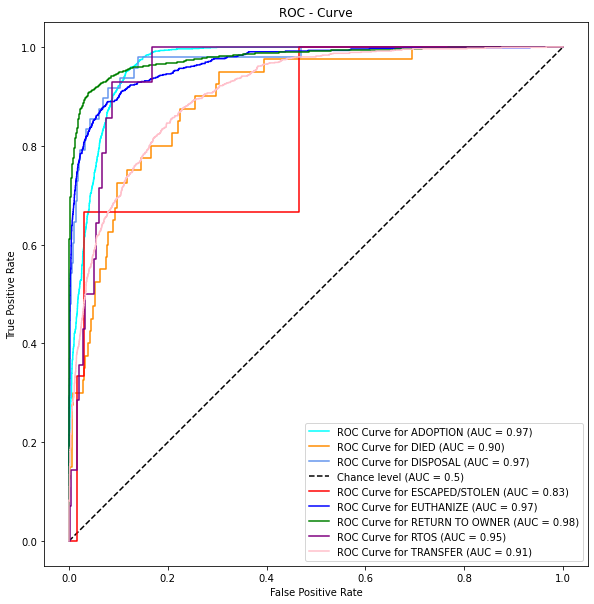

In [110]:
generate_roc_curve(best_lgbm)

In [111]:
# # Save the model to a file using pickle
# with open('lgbm_model.pkl', 'wb') as file:
#     pickle.dump(best_lgbm, file)

## 4) Light GBM Classifier with GridSearchCV

In [135]:
# Hyperparameter tuning
# Define the parameter grid for RandomizedSearchCV

param_dist = {
    'boosting_type': ['gbdt'],
    'num_leaves': [111, 112, 113],
    'learning_rate': [0.05, 0.1, 1.5],
    'subsample': [0.83030303, 0.83838384, 0.84646465],
    'colsample_bytree': [1, 2],
    'max_bin': [16, 32, 64],
    'max_depth': [1, 2, 3],
    'objective': ['multiclass'],
    'num_class': [8]
}


## Create a LightGBM classifier
lgb_classifier_2 = lgb.LGBMClassifier()

# Get the best parameters
best_params = grid_hyperparameter_tuning(model=lgb_classifier_2, param_dist=param_dist)

D:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
729 fits failed out of a total of 1458.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
729 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 1142, in fit
    super().fit(
  File "D:\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 842, in fit
    self._Booster = train(
  File "D:\Anaconda3\lib\site-packages\lightgbm\engine.py", line 245, in train
    booster = Booster(params=params, train_set=tra

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000788 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 192
[LightGBM] [Info] Number of data points in the train set: 20481, number of used features: 14
[LightGBM] [Info] Start training from score -1.227238
[LightGBM] [Info] Start training from score -5.052056
[LightGBM] [Info] Start training from score -4.696144
[LightGBM] [Info] Start training from score -7.288196
[LightGBM] [Info] Start training from score -1.976398
[LightGBM] [Info] Start training from score -1.085371
[LightGBM] [Info] Start training from score -6.371905
[LightGBM] [Info] Start training from score -1.548173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

In [136]:
best_params

{'boosting_type': 'gbdt',
 'colsample_bytree': 1,
 'learning_rate': 0.05,
 'max_bin': 32,
 'max_depth': 3,
 'num_class': 8,
 'num_leaves': 111,
 'objective': 'multiclass',
 'subsample': 0.83030303}

In [137]:
# Train the model with best parameters
best_lgbm_2 = lgb.LGBMClassifier(random_state=42, **best_params)
# best_lgbm = LGBMClassifier(random_state=42)
best_lgbm_2.fit(X_train, y_train)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000789 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 192
[LightGBM] [Info] Number of data points in the train set: 20481, number of used features: 14
[LightGBM] [Info] Start training from score -1.227238
[LightGBM] [Info] Start training from score -5.052056
[LightGBM] [Info] Start training from score -4.696144
[LightGBM] [Info] Start training from score -7.288196
[LightGBM] [Info] Start training from score -1.976398
[LightGBM] [Info] Start training from score -1.085371
[LightGBM] [Info] Start training from score -6.371905
[LightGBM] [Info] Start training from score -1.548173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

LGBMClassifier(colsample_bytree=1, learning_rate=0.05, max_bin=32, max_depth=3,
               num_class=8, num_leaves=111, objective='multiclass',
               random_state=42, subsample=0.83030303)

In [138]:
eval_model(best_lgbm_2)

Training Accuracy Score: 0.8321371026805332
Test Accuracy Score: 0.8217145088849834


Classification Report:
                  precision    recall  f1-score   support

       ADOPTION       0.78      0.93      0.85      1530
           DIED       1.00      0.05      0.10        40
       DISPOSAL       0.72      0.38      0.49        48
 ESCAPED/STOLEN       1.00      0.00      0.00         3
      EUTHANIZE       0.90      0.73      0.80       714
RETURN TO OWNER       0.91      0.91      0.91      1688
           RTOS       1.00      0.00      0.00        14
       TRANSFER       0.69      0.65      0.67      1084

       accuracy                           0.82      5121
      macro avg       0.88      0.46      0.48      5121
   weighted avg       0.83      0.82      0.81      5121



In [139]:
roc_auc_score_per_class(best_lgbm_2)

Class ADOPTION ROC-AUC: 0.97
Class DIED ROC-AUC: 0.90
Class DISPOSAL ROC-AUC: 0.97
Class ESCAPED/STOLEN ROC-AUC: 0.86
Class EUTHANIZE ROC-AUC: 0.97
Class RETURN TO OWNER ROC-AUC: 0.98
Class RTOS ROC-AUC: 0.95
Class TRANSFER ROC-AUC: 0.91


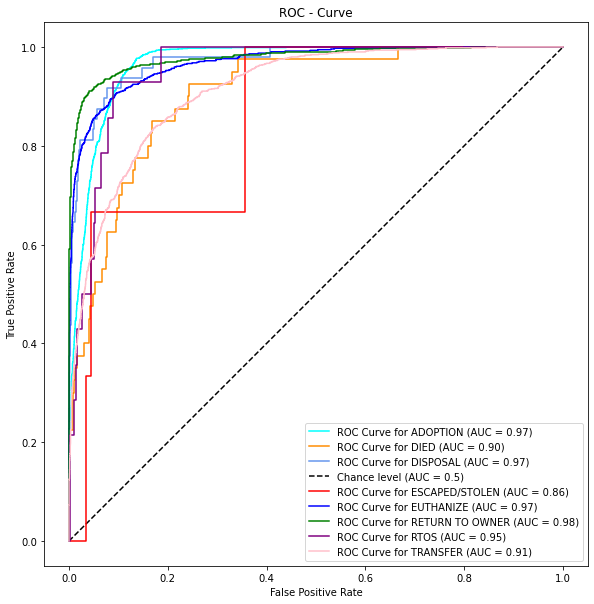

In [140]:
generate_roc_curve(best_lgbm_2)

In [142]:
# # Save the model to a file using pickle
# with open('grid_lgbm_model.pkl', 'wb') as file:
#     pickle.dump(best_lgbm_2, file)

## 5) XGBoost Classifier

In [149]:
# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': np.arange(50, 251, 50),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'max_depth': np.arange(3, 11),
    'min_child_weight': np.arange(1, 11),
    'subsample': np.linspace(0.6, 1.0, 5),
    'colsample_bytree': np.linspace(0.6, 1.0, 5),
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5]
}

# Initialize the XGBoost classifier
xgb = XGBClassifier(objective='multi:softmax', num_class=8)

best_params = xgb_hyperparameter_tuning(model=xgb, param_dist=param_dist, n_iter=300)

best_params

D:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
456 fits failed out of a total of 900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
456 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda3\lib\site-packages\xgboost\core.py", line 575, in inner_f
    return f(**kwargs)
  File "D:\Anaconda3\lib\site-packages\xgboost\sklearn.py", line 1400, in fit
    self._Booster = train(
  File "D:\Anaconda3\lib\site-packages\xgboost\core.py", line 575, in inner_f
    return f(**kwargs)
  File "D:\Anaconda3\lib

[02:01:59] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "boosting_type", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




{'subsample': 0.83838384,
 'objective': 'multiclass',
 'num_leaves': 111,
 'num_class': 8,
 'max_depth': 3,
 'max_bin': 64,
 'learning_rate': 0.1,
 'colsample_bytree': 1,
 'boosting_type': 'gbdt'}

In [150]:
# Train the model with best parameters
best_xgb = XGBClassifier(random_state=42, **best_params)
# best_lgbm = LGBMClassifier(random_state=42)
best_xgb.fit(X_train, y_train_encoded)

[02:06:06] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "boosting_type", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBClassifier(base_score=0.5, booster='gbtree', boosting_type='gbdt',
              callbacks=None, colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=1, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=64,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=3, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_class=8, num_leaves=111,
              num_parallel_tree=1, objective='multi:softprob', ...)

In [153]:
eval_model(best_xgb, y_train=y_train_encoded, y_test=y_test_encoded)

Training Accuracy Score: 0.8392168351154728
Test Accuracy Score: 0.824838898652607


Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.93      0.86      1530
           1       1.00      0.05      0.10        40
           2       0.70      0.29      0.41        48
           3       1.00      0.00      0.00         3
           4       0.90      0.74      0.81       714
           5       0.91      0.91      0.91      1688
           6       1.00      0.00      0.00        14
           7       0.70      0.66      0.68      1084

    accuracy                           0.82      5121
   macro avg       0.87      0.45      0.47      5121
weighted avg       0.83      0.82      0.82      5121



In [155]:
roc_auc_score_per_class(best_xgb, y_test=y_test_encoded)

Class 0 ROC-AUC: 0.97
Class 1 ROC-AUC: 0.92
Class 2 ROC-AUC: 0.97
Class 3 ROC-AUC: 0.74
Class 4 ROC-AUC: 0.97
Class 5 ROC-AUC: 0.98
Class 6 ROC-AUC: 0.93
Class 7 ROC-AUC: 0.92


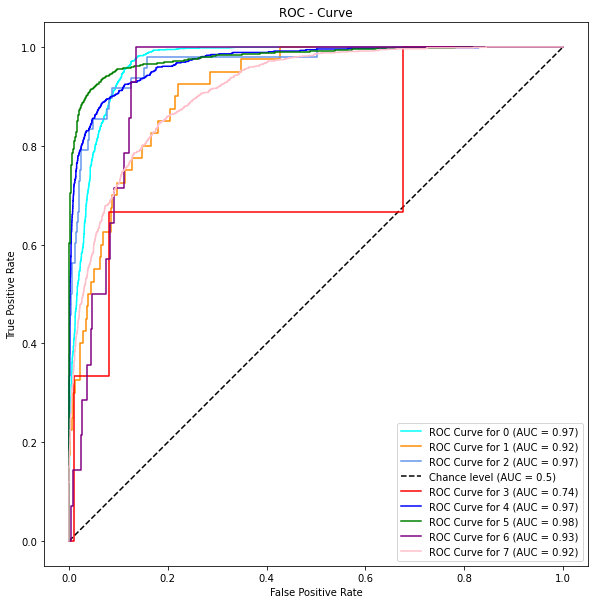

In [156]:
generate_roc_curve(best_xgb, y_train=y_train_encoded, y_test=y_test_encoded)

In [157]:
# # Save the model to a file using pickle
# with open('xgb_model.pkl', 'wb') as file:
#     pickle.dump(best_xgb, file)